## Import modules

In [1]:
import os
import numpy as np
import math
import statistics
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Load output test probabilitites and true labels for each model

For every model there are 2 files generated in numpy binary format:

  **probabilities.npy** - numpy array of size **TEST POINT CLOUDS CLOUD x CLASSES COUNT x MODELS COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

In [2]:
# Base models
BASE_MODELS = ['pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets', 'dgcnn', 'pointcnn']
BASE_MODELS_ALIASES = ['PointNet', 'PointNet++', 'SO-Net', 'KCNet', 'DeepSets', 'DGCNN', 'PointCNN']
SONET_BAGGING_MODELS = ['so-net_sz_01', 'so-net_sz_02', 'so-net_sz_03', 'so-net_sz_04', 'so-net_sz_05', 'so-net_sz_06',
                        'so-net_sz_07', 'so-net_sz_08', 'so-net_sz_09', 'so-net_bagging']
SONET_CONST_MODELS = ['so-net_TTT', 'so-net_FFT', 'so-net_FTF', 'so-net_TFF', 'so-net_TTF', 'so-net_TFT', 'so-net_FTT']
SONET_CLASSIFIER_ENSEMBLE = ['so-net_' + str(i) for i in range(1, 11)]
ALL_MODELS = BASE_MODELS + SONET_BAGGING_MODELS + SONET_CONST_MODELS + SONET_CLASSIFIER_ENSEMBLE

CLASS_NAMES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl',
               'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser',
               'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop',
               'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio',
               'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet',
               'tv_stand', 'vase', 'wardrobe', 'xbox']
CLASS_TEST_INSTANCES = [100, 50, 100, 20, 100, 100, 20, 100, 100, 20, 20, 20, 86, 20,
                        86, 20, 100, 100, 20, 20, 20, 100, 100, 86, 20, 100, 100, 20,
                        100, 20, 100, 20, 20, 100, 20, 100, 100, 100, 20, 20]
CLASSES_COUNT = 40
# MODELS_COUNT = 10
# ENSEMBLE_MODELS_NUMBER = 10

probabilities = {}
true_labels = {}
for model in ALL_MODELS:
    for dir_name in ['models_reordered', 'models_raw', 'models_bagging', 'models_const', 'models_classifier_ensemble']:
        if os.path.exists(os.path.join(dir_name, model)):
            break
    prob_filepath = os.path.join(os.path.join(dir_name, model), 'probabilities.npy')
    label_filepath = os.path.join(os.path.join(dir_name, model), 'true_labels.npy')
    probabilities[model] = np.load(prob_filepath)
    if dir_name != 'models_reordered':
        probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))

    # probabilities[model] =  softmax(probabilities[model])
    idx = np.argmax(probabilities[model], axis=-1)
    hardvote = np.squeeze(np.eye(40)[idx.reshape(-1)]).reshape(probabilities[model].shape)
    e_x = np.exp(probabilities[model])
    softvote = e_x /np.expand_dims(np.sum(e_x, axis=-1), axis=-1)
    probabilities[model] = {'activations': probabilities[model]/np.std(probabilities[model]),
                           'hardvote': hardvote, 'softvote': softvote}
    true_labels[model] = np.load(label_filepath)
    
    for class_idx in range(CLASSES_COUNT):
        error_info = ("Test cloud instances for model " + model + " and class "
                      + str(class_idx) + " differs! Should be " + str(CLASS_TEST_INSTANCES[class_idx])
                      + " but got " + str(np.sum(true_labels[model] == class_idx)))
        assert np.sum(true_labels[model] == class_idx) == CLASS_TEST_INSTANCES[class_idx] or \
          (model=='deepsets' and class_idx==12 and np.sum(true_labels[model] == class_idx) == 85) or \
          (model=='deepsets' and class_idx==39 and np.sum(true_labels[model] == class_idx) == 19) or \
          (model=='deepsets_ep100' and class_idx==12 and np.sum(true_labels[model] == class_idx) == 85) or \
          (model=='deepsets_ep100' and class_idx==39 and np.sum(true_labels[model] == class_idx) == 19), \
          error_info
                
#     assert (probabilities[model].shape[0] == ENSEMBLE_MODELS_NUMBER)
    assert (probabilities[model]['activations'].shape[1] == 2468 or \
            (model=='deepsets' and probabilities[model]['activations'].shape[1] == 2466) or \
           (model=='deepsets_ep100' and probabilities[model]['activations'].shape[1] == 2466))
    assert (probabilities[model]['activations'].shape[2] == CLASSES_COUNT)

## Caclulate statistics

In [36]:
####################################################################################
# Get random subsets
####################################################################################

def get_k_combinations_of_n_elems(n, k, rep):
    """
    Get rep different k-combinations of set of n numbers. If requested reps is greater
    than possible combinations number just return all possible combinations. In our case:
    n - maximum number of ensembled models
    k - actual number of ensembled models
    rep - how many different k subsets of n we want to generate.    
    """
    c_n_k = math.factorial(n) / math.factorial(k) / math.factorial(n-k)
    combinations_number = min(c_n_k, rep)
    
    subsets = []   
    while len(subsets) != combinations_number:
        candidate = np.sort(np.random.choice(n, k, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)
        
####################################################################################
# Calc accuracy statistics
####################################################################################

def get_stats_for_num_ens_param(params_list):
    stats = {}
    stats['mean'] = statistics.mean(params_list)
    stats['stddev'] = statistics.stdev(params_list) if len(params_list) > 1 else 0.0
    stats['median'] = statistics.median(params_list)
    stats['min'] = min(params_list)
    stats['max'] = max(params_list)
    return stats

def get_accuracy_stats(models_list, voting_method='activations'):
    accuracy_stats = {}
    for model in models_list:
        subsets = {}
        
        num_ensemble_models = probabilities[model][voting_method].shape[0]
        for num_ens in range(1, num_ensemble_models+1):
            subset = get_k_combinations_of_n_elems(len(probabilities[model][voting_method]),
                                                   num_ens, 100)
            subsets[num_ens] = subset
            
        accuracy_stats[model] = {}

        for num_ens in subsets:
            num_ens_accs = []
            for subset in subsets[num_ens]:
                preds = np.argmax(np.mean(probabilities[model][voting_method][subset], axis=0), axis=-1)
                true = true_labels[model]

                acc = float(np.sum(preds == true))/len(true)
                class_accs = []
                for class_idx in range(CLASSES_COUNT):
                    class_acc = float(np.sum((preds == true) * (true == class_idx)))/float(np.sum(true == class_idx))
                    class_accs.append(class_acc)
                mean_class_acc = statistics.mean(class_accs)
                num_ens_accs.append({'acc': acc, 'mean_class_acc': mean_class_acc, 'class_accs': class_accs})

            num_ens_summary = {}
            num_ens_summary['acc'] = get_stats_for_num_ens_param([x['acc'] for x in num_ens_accs])
            num_ens_summary['mean_class_acc'] = get_stats_for_num_ens_param([x['mean_class_acc'] for x in num_ens_accs])
            num_ens_summary['class_accs'] = []
            for class_idx in range(CLASSES_COUNT):
                num_ens_summary['class_accs'].append(get_stats_for_num_ens_param([x['class_accs'][class_idx] 
                                                                                  for x in num_ens_accs]))
            accuracy_stats[model][num_ens] = num_ens_summary
    return accuracy_stats

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

def plot_acc_in_num_models(ax, acc_stats, acc_type='acc', styles={}, h_factor=0.1,
                           times=None, without_errorbar=False):
    for model in acc_stats:
        
        if model not in list(styles.keys()):
            continue
        
        x = acc_stats[model].keys()
        y = [acc_stats[model][i][acc_type]['mean'] for i in x]
        if 'stddev' in acc_stats[model][1][acc_type] and not without_errorbar:
            e = [acc_stats[model][i][acc_type]['stddev'] for i in x]
        if times is not None:
            x = [v * times[model] for v in x]
        if 'stddev' in acc_stats[model][1][acc_type] and not without_errorbar:
            ax.errorbar(x, y, e,
                        label=styles[model]['label'],
                        color=styles[model]['color'],
                        linestyle=styles[model]['linestyle'],
                        linewidth=styles[model]['linewidth'],
                        capsize=6)
        else:
            ax.plot(x, y,
                    label=styles[model]['label'],
                    color=styles[model]['color'],
                    linestyle=styles[model]['linestyle'],
                    #dashes=styles[model]['dashes'],
                    linewidth=styles[model]['linewidth'])
       
    if times is None:
        ax.set_xlabel('Number of ensembled models')
    else:
        ax.set_xlabel('Inference time for batch of 4 point clouds [ms]')
        
    if acc_type == 'acc':
        ax.set_ylabel('Instance classification accuracy')
    elif acc_type == 'mean_class_acc':
        ax.set_ylabel('Mean class accuracy')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * h_factor,
                     box.width, box.height * (1.0 - h_factor)])
    
    # logsclae
    ax.set_yscale('linear')
    
    # Show tick labels
    for tk in ax.get_yticklabels():
        tk.set_visible(True)
        
    return ax.get_legend_handles_labels()

## Accuracies in function of ensemled models for SO-Net bagging

In [4]:
acc_stats_sonet_bagging = get_accuracy_stats(SONET_BAGGING_MODELS + ['so-net'])

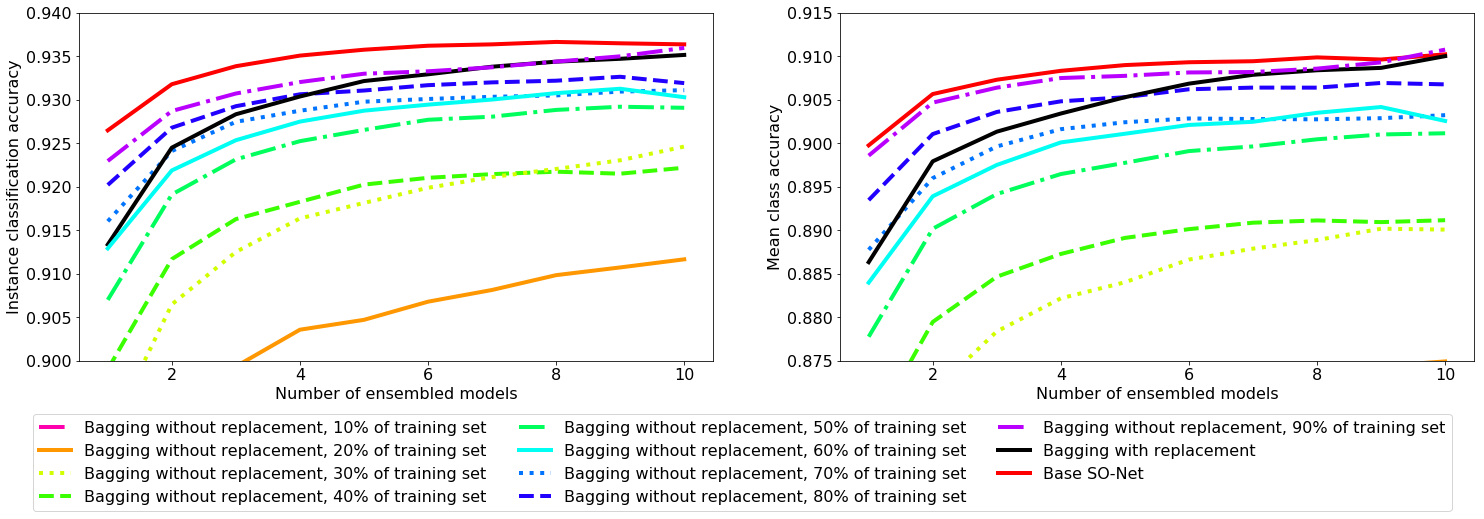

In [29]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(11)
linewidth = 4
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(25, 8))
styles = {'so-net': {'color': 'r', 'linestyle': '-', 'dashes' : [13,1], 'label': 'Base SO-Net', 'linewidth' : linewidth},
          'so-net_sz_01': {'color': cmap(9), 'linestyle': '-.', 'dashes' : [12,2], 'label': 'Bagging without replacement, 10% of training set', 'linewidth' : linewidth},
          'so-net_sz_02': {'color': cmap(1), 'linestyle': '-', 'dashes' : [12,3], 'label': 'Bagging without replacement, 20% of training set', 'linewidth' : linewidth},
          'so-net_sz_03': {'color': cmap(2), 'linestyle': ':', 'dashes' : [11,4], 'label': 'Bagging without replacement, 30% of training set', 'linewidth' : linewidth},
          'so-net_sz_04': {'color': cmap(3), 'linestyle': '--', 'dashes' : [10,5], 'label': 'Bagging without replacement, 40% of training set', 'linewidth' : linewidth},
          'so-net_sz_05': {'color': cmap(4), 'linestyle': '-.', 'dashes' : [9,6], 'label': 'Bagging without replacement, 50% of training set', 'linewidth' : linewidth},
          'so-net_sz_06': {'color': cmap(5), 'linestyle': '-', 'dashes' : [8,7], 'label': 'Bagging without replacement, 60% of training set', 'linewidth' : linewidth},
          'so-net_sz_07': {'color': cmap(6), 'linestyle': ':', 'dashes' : [7,8], 'label': 'Bagging without replacement, 70% of training set', 'linewidth' : linewidth},
          'so-net_sz_08': {'color': cmap(7), 'linestyle': '--', 'dashes' : [6,9], 'label': 'Bagging without replacement, 80% of training set', 'linewidth' : linewidth},
          'so-net_sz_09': {'color': cmap(8), 'linestyle': '-.', 'dashes' : [5,10], 'label': 'Bagging without replacement, 90% of training set', 'linewidth' : linewidth},
          'so-net_bagging': {'color': 'black', 'linestyle': '-', 'dashes' : [6,2], 'label': 'Bagging with replacement', 'linewidth' : linewidth}
         }
h = 0.2
handles, labels = plot_acc_in_num_models(ax1, acc_stats_sonet_bagging, 'acc', styles, h, without_errorbar=True)
plot_acc_in_num_models(ax2, acc_stats_sonet_bagging, 'mean_class_acc', styles, h, without_errorbar=True)

# Order handles and labels
order = []
for percent in np.array(np.linspace(10, 90, 9)).astype(int):
    asd = [idx for idx, label in enumerate(labels) if str(percent) in label]
    if len(asd):
        order.append(asd[0])
order.append([idx for idx, label in enumerate(labels) if 'Bagging with replacement' == label][0])
order.append([idx for idx, label in enumerate(labels) if 'Base SO-Net' == label][0])
labels = np.array(labels)[order].tolist()
handles = np.array(handles)[order].tolist()

f.legend(handles=handles, loc='lower center', ncol=3)
ax1.set_ylim((0.90, 0.94))
ax2.set_ylim((0.875, 0.915))
f.savefig('images/sonet_bagging_color.png', bbox_inches='tight')

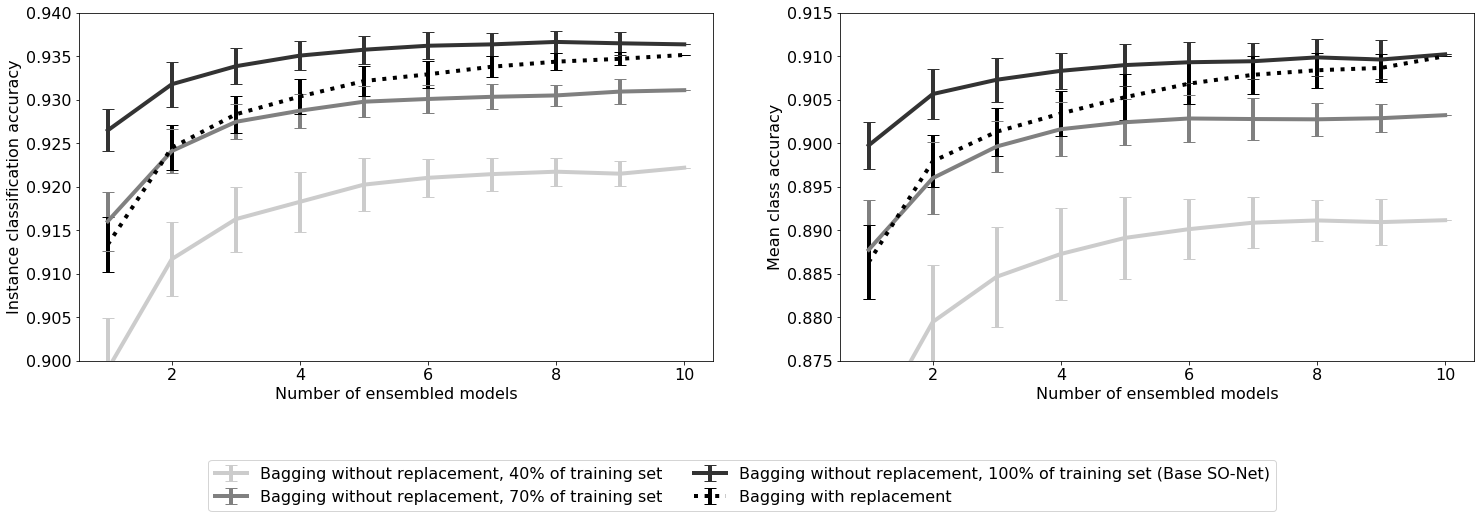

In [59]:
linewidth = 4
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(25, 8))
styles_gray = {#'so-net': {'color': 'r', 'linestyle': '-', 'dashes' : [13,1], 'label': 'Base SO-Net', 'linewidth' : linewidth},
          'so-net': {'color': [0.2, 0.2, 0.2], 'linestyle': '-', 'dashes' : [13,1], 'label': 'Bagging without replacement, 100% of training set (Base SO-Net)', 'linewidth' : linewidth},
          #'so-net_sz_01': {'color': cmap(9), 'linestyle': '-.', 'dashes' : [12,2], 'label': 'Bagging without replacement, 10% of training set', 'linewidth' : linewidth},
          #'so-net_sz_02': {'color': cmap(1), 'linestyle': '-', 'dashes' : [12,3], 'label': 'Bagging without replacement, 20% of training set', 'linewidth' : linewidth},
          #'so-net_sz_03': {'color': cmap(2), 'linestyle': ':', 'dashes' : [11,4], 'label': 'Bagging without replacement, 30% of training set', 'linewidth' : linewidth},
          'so-net_sz_04': {'color': [0.8, 0.8, 0.8], 'linestyle': '-', 'dashes' : [10,5], 'label': 'Bagging without replacement, 40% of training set', 'linewidth' : linewidth},
          #'so-net_sz_05': {'color': cmap(4), 'linestyle': '-.', 'dashes' : [9,6], 'label': 'Bagging without replacement, 50% of training set', 'linewidth' : linewidth},
          #'so-net_sz_06': {'color': cmap(5), 'linestyle': '-', 'dashes' : [8,7], 'label': 'Bagging without replacement, 60% of training set', 'linewidth' : linewidth},
          'so-net_sz_07': {'color': [0.5, 0.5, 0.5], 'linestyle': '-', 'dashes' : [7,8], 'label': 'Bagging without replacement, 70% of training set', 'linewidth' : linewidth},
          #'so-net_sz_08': {'color': cmap(7), 'linestyle': '--', 'dashes' : [6,9], 'label': 'Bagging without replacement, 80% of training set', 'linewidth' : linewidth},
          #'so-net_sz_09': {'color': cmap(8), 'linestyle': '-.', 'dashes' : [5,10], 'label': 'Bagging without replacement, 90% of training set', 'linewidth' : linewidth},
          'so-net_bagging': {'color': 'black', 'linestyle': ':', 'dashes' : [6,2], 'label': 'Bagging with replacement', 'linewidth' : linewidth}
         }
h = 0.2
handles, labels = plot_acc_in_num_models(ax1, acc_stats_sonet_bagging, 'acc',
                                         styles_gray, h, without_errorbar=False)
plot_acc_in_num_models(ax2, acc_stats_sonet_bagging, 'mean_class_acc',
                       styles_gray, h, without_errorbar=False)

# Order handles and labels
order = [0, 2, 1, 3]
labels = np.array(labels)[order].tolist()
handles = [handles[i] for i in order]
#handles = np.array(handles)[order].tolist()

f.legend(handles=handles, loc='lower center', ncol=2)
ax1.set_ylim((0.90, 0.94))
ax2.set_ylim((0.875, 0.915))
f.savefig('images/sonet_bagging_grayscale.png', bbox_inches='tight')